# Trabajo Práctico 4
*   Arelis Picado
*   Diego Solís
*   Isaac Vargas

### Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 1. **(80 puntos)** Algoritmo de Maximización de la Esperanza con datos artificiales (modelo Gaussiano)


A continuación, implemente el algoritmo de maximización de la esperanza (descrito en el material del curso), usando la definición y descripción de las siguientes funciones como base:

##### 1.   **(15 puntos)** Implemente la función generate_data, la cual reciba la cantidad de observaciones unidimensionales total a generar N, y los parámetros correspondientes a $K=2$ funciones de densidad Gaussianas. Genere los datos siguiendo tales distribuciones, y retorne tal matriz de datos $X\in\mathbb{R}^{N\times1}$.

a) Grafique los datos usando un scatter plot junto con las gráficas de los histogramas de los datos y las funciones de densidad de probabilidad Gaussianas usando los parámetros para inicializar los datos, en la misma figura (gráfico). Escoja 3 conjuntos de parámetros para mostrar los 3 datasets resultantes.

In [2]:
def generate_data(N, mu1, sigma1, mu2, sigma2, pi1=0.5, pi2=0.5):
    """
    Generates data following a mixture of two Gaussian distributions.

    Parameters:
    - N: Total number of observations to generate.
    - mu1, sigma1: Mean and standard deviation for the first Gaussian.
    - mu2, sigma2: Mean and standard deviation for the second Gaussian.
    - pi1, pi2: Weights (membership probabilities) for each Gaussian distribution.

    Returns:
    - X: Generated data matrix of size (N, 1).
    """
    # Generate labels for each sample according to probabilities pi1 and pi2
    labels = np.random.choice([0, 1], size=N, p=[pi1, pi2])

    # Generate data for each label according to the corresponding Gaussian
    X = np.zeros(N)
    X[labels == 0] = np.random.normal(mu1, sigma1, size=(labels == 0).sum())
    X[labels == 1] = np.random.normal(mu2, sigma2, size=(labels == 1).sum())

    return X.reshape(-1, 1)  # Return as a column vector

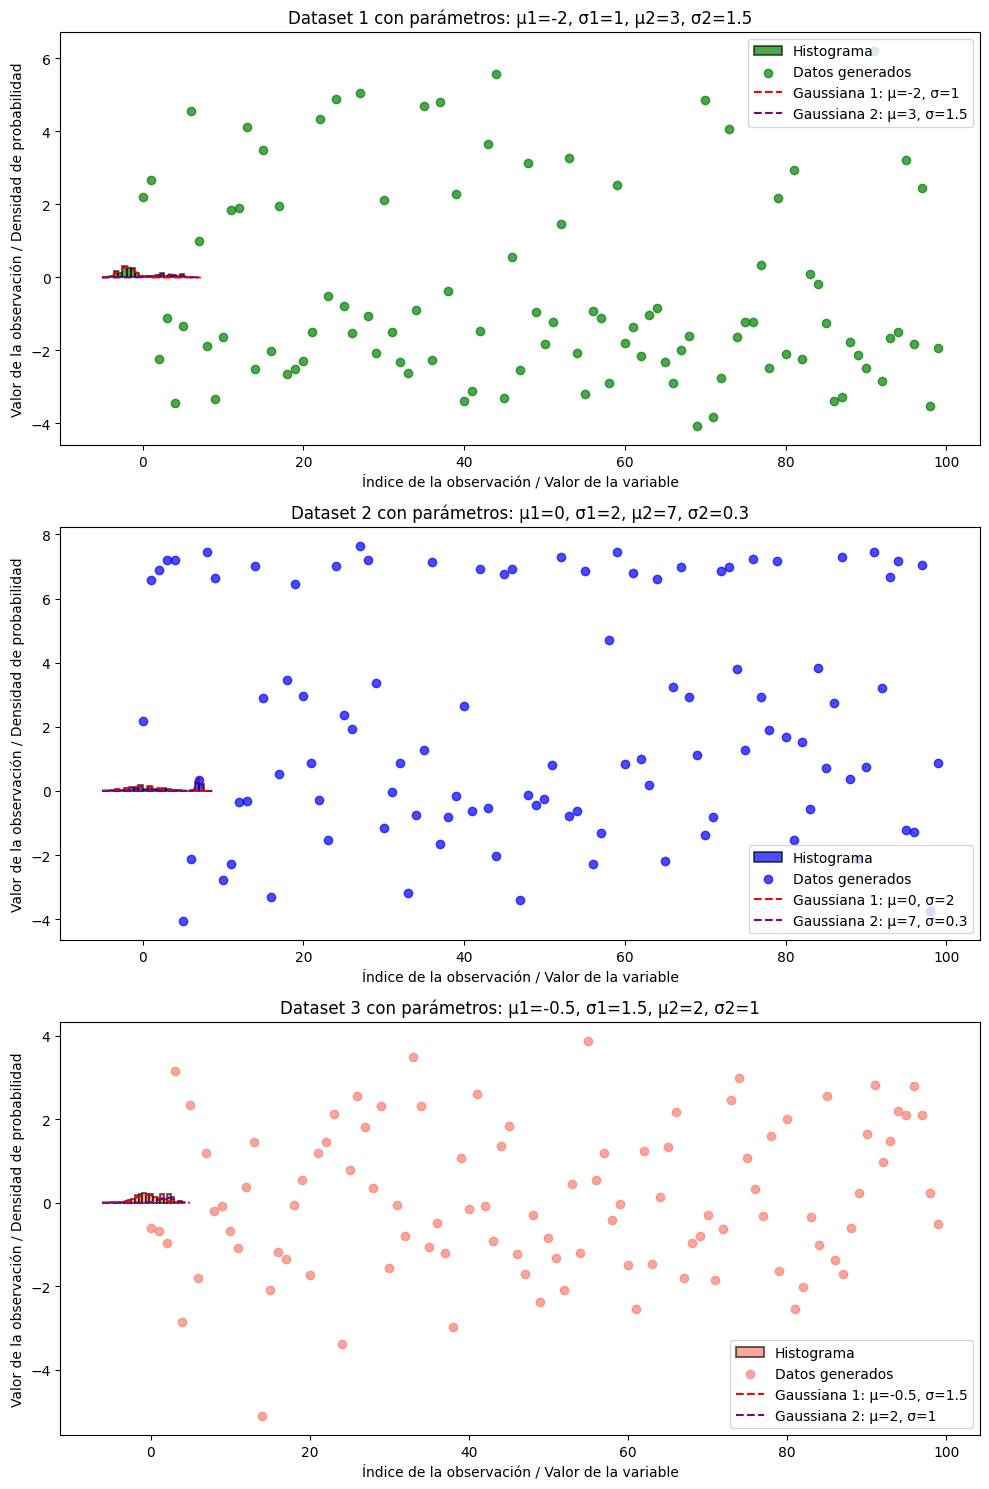

In [3]:
# Data parameters
parameters = [
    (100, -2, 1, 3, 1.5),
    (100, 0, 2, 7, 0.3),
    (100, -0.5, 1.5, 2, 1)
]

# Color for dataset
colors = ['green', 'blue', 'salmon']

fig, axs = plt.subplots(3, 1, figsize=(10, 15))
for i, (N, mu1, sigma1, mu2, sigma2) in enumerate(parameters):
    pi1, pi2 = 0.7, 0.3  # Probabilidades de mezcla

    # Scatter plot and histogram
    X = generate_data(N, mu1, sigma1, mu2, sigma2, pi1=pi1, pi2=pi2)
    axs[i].hist(X, bins=20, density=True, alpha=0.7, color=colors[i], label="Histograma", edgecolor='black', linewidth=1.2)
    axs[i].scatter(np.arange(N), X, color=colors[i], alpha=0.7, label="Datos generados")

    # Probability density functions
    x_vals = np.linspace(X.min() - 1, X.max() + 1, 500)
    pdf1 = norm.pdf(x_vals, mu1, sigma1) * pi1
    pdf2 = norm.pdf(x_vals, mu2, sigma2) * pi2
    axs[i].plot(x_vals, pdf1, color='red', linestyle='--', label=f"Gaussiana 1: μ={mu1}, σ={sigma1}")
    axs[i].plot(x_vals, pdf2, color='purple', linestyle='--', label=f"Gaussiana 2: μ={mu2}, σ={sigma2}")

    axs[i].set_title(f"Dataset {i+1} con parámetros: μ1={mu1}, σ1={sigma1}, μ2={mu2}, σ2={sigma2}")
    axs[i].set_xlabel("Índice de la observación / Valor de la variable")
    axs[i].set_ylabel("Valor de la observación / Densidad de probabilidad")
    axs[i].legend()

plt.tight_layout()
plt.show()

##### 2.   **(5 puntos)** Implemente la función init_random_parameters la cual genere una matriz de $P\in\mathbb{R}^{K\times2}$ dimensiones, con los parámetros de las funciones de densidad Gaussiana generados completamente al azar.

a) Muestre un pantallazo donde verifique su funcionamiento correcto con los comentarios asociados.

In [4]:
def init_random_parameters(K=2):
    """
    Initializes random parameters for K Gaussian distributions.

    Returns:
    - P (numpy array): Matrix of dimensions (K, 2) where each row represents
      (mean, standard deviation) for each Gaussian distribution.
    """
    # Generate K random means and standard deviations
    # mu (mean) is generated between -10 and 10
    # sigma (standard deviation) is ensured to be positive (between 0.1 and 5)
    mu = np.random.uniform(-10, 10, size=K)
    sigma = np.random.uniform(0.1, 5, size=K)

    # Combine into a matrix of dimensions (K, 2)
    P = np.column_stack((mu, sigma))

    return P

In [5]:
# Random
for i in range(3):
    P = init_random_parameters(K=2)
    print(f"Matriz de parámetros aleatorios P (Ejemplo {i+1}):\n", P, "\n")

Matriz de parámetros aleatorios P (Ejemplo 1):
 [[-8.91723677  0.38660603]
 [ 5.42727681  3.84659323]] 

Matriz de parámetros aleatorios P (Ejemplo 2):
 [[3.29321098 0.39061609]
 [6.35467366 0.55611129]] 

Matriz de parámetros aleatorios P (Ejemplo 3):
 [[ 6.97739299  2.99677491]
 [-5.12124249  4.87293166]] 



##### 3.   **(20 puntos)** Implemente la función calculate_likelihood_gaussian_observation(x_n, mu_k, sigma_k) la cual calcule la verosimilitud de una observación específica $x_{n}$, para una función de densidad Gaussiana con parámetros $\mu_{k}$ y $\sigma_{k}$. Realice la corrección pertinente al cálculo de la función de verosimilitud para evitar el problema de under flow.

a) Diseñe y ejecute una prueba unitaria donde verifique su funcionamiento correcto con los comentarios asociados.

In [16]:
def calculate_likelihood_gaussian_observation(x_n, mu_k, sigma_k):
    """
    Calculates the likelihood of a specific observation x_n for a Gaussian
    distribution with mean mu_k and standard deviation sigma_k.
    The logarithm of the probability density is used to avoid underflow.

    Parameters:
    - x_n: Value of the observation.
    - mu_k: Mean of the Gaussian distribution.
    - sigma_k: Standard deviation of the Gaussian distribution.

    Returns:
    - The likelihood of x_n under the Gaussian distribution with mean mu_k and sigma_k.
    """
    # Calculate the logarithm of the Gaussian probability density
    log_likelihood = -0.5 * np.log(2 * np.pi * sigma_k ** 2) - ((x_n - mu_k) ** 2) / (2 * sigma_k ** 2)
    # Convert from log-likelihood to likelihood
    likelihood = np.exp(log_likelihood)
    return likelihood

In [17]:
def unitTest_calculate_likelihood_gaussian_observation():
    """
    Unit test for the function calculate_likelihood_gaussian_observation.
    Verifies that the function correctly computes the likelihood for a given observation.
    """
    # Test parameters
    x_n = 0
    mu_k = 0
    sigma_k = 1

    # Expected likelihood calculation using the Gaussian density formula
    expected_likelihood = (1 / (np.sqrt(2 * np.pi) * sigma_k)) * np.exp(-0.5 * ((x_n - mu_k) / sigma_k) ** 2)

    # Calculate likelihood using the function
    calculated_likelihood = calculate_likelihood_gaussian_observation(x_n, mu_k, sigma_k)

    # Check if the calculated value is approximately equal to the expected value
    assert np.isclose(calculated_likelihood, expected_likelihood, atol=1e-9), \
        f"Test failed: calculated likelihood is {calculated_likelihood}, expected {expected_likelihood}"

    print("Test passed: Calculated likelihood matches the expected value.")

# Run the unit test
unitTest_calculate_likelihood_gaussian_observation()

Test passed: Calculated likelihood matches the expected value.


##### 4.   **(10 puntos)** Implemente la función calculate_membership_dataset(X_dataset, Parameters_matrix), la cual, usando la matriz de parámetros P y la función anteriormente implementada calculate_likelihood_gaussian_observation, defina por cada observación $x_{n}\in X$ la pertenencia o membresía a cada cluster $k=1$,$\ldots K$, en una matriz binaria $M\in\mathbb{R}^{N\times K}$. Retorne tal matriz de membresía M.

a) Diseñe y ejecute una prueba unitaria donde verifique su funcionamiento correcto con los comentarios asociados.

In [21]:
def calculate_membership_dataset(X_dataset, Parameters_matrix):
    """
    Calculates the membership matrix for a dataset based on Gaussian parameters.

    Parameters:
    - X_dataset: Dataset (numpy array of shape (N, 1)), where N is the number of observations.
    - Parameters_matrix: Matrix of Gaussian parameters (numpy array of shape (K, 2)), where K is the number of clusters.
                         Each row represents (mean, standard deviation) for a Gaussian.

    Returns:
    - M: Binary membership matrix of shape (N, K), where each entry is 1 if the observation belongs to the cluster with the highest likelihood.
    """
    N = X_dataset.shape[0]
    K = Parameters_matrix.shape[0]
    
    # Initialize the membership matrix with zeros
    M = np.zeros((N, K))
    
    # Calculate likelihoods and assign membership
    for i in range(N):
        x_n = X_dataset[i, 0]
        
        # Calculate likelihood for each Gaussian and store in list
        likelihoods = [
            calculate_likelihood_gaussian_observation(x_n, Parameters_matrix[k, 0], Parameters_matrix[k, 1])
            for k in range(K)
        ]

        print(f"Observation {x_n}: Likelihoods = {likelihoods}")  # Debug print
        max_likelihood_index = np.argmax(likelihoods)
        print(f"Assigned to Gaussian {max_likelihood_index}")  # Debug print
        
        # Find the index of the Gaussian with the highest likelihood
        max_likelihood_index = np.argmax(likelihoods)
        
        # Assign membership to the cluster with the highest likelihood
        M[i, max_likelihood_index] = 1

    return M




In [23]:
def unitTest_calculate_membership_dataset():
    """
    Unit test for the function calculate_membership_dataset.
    Verifies that the function correctly computes the membership matrix for a given dataset.
    """
    # Test dataset
    X_test = np.array([[1.0], [4.0], [7.0]])
    
    # Test parameters (2 Gaussians with different means)
    P_test = np.array([
        [2.0, 1.0],  # Gaussian 1 with mean 2 and standard deviation 1
        [6.0, 1.0]   # Gaussian 2 with mean 6 and standard deviation 1
    ])
    
    # Expected membership matrix based on likelihoods
    expected_M = np.array([
        [1, 0],  # Closer to Gaussian 1
        [1, 0],  # Tied likelihoods, assigned to Gaussian 1
        [0, 1]   # Closer to Gaussian 2
    ])
    
    # Calculate membership matrix using the function
    calculated_M = calculate_membership_dataset(X_test, P_test)
    
    # Check if the calculated matrix matches the expected matrix
    assert np.array_equal(calculated_M, expected_M), \
        f"Test failed: calculated membership matrix is {calculated_M}, expected {expected_M}"
    
    print("Test passed: Calculated membership matrix matches the expected matrix.")

# Run the unit test
unitTest_calculate_membership_dataset()



Observation 1.0: Likelihoods = [0.24197072451914337, 1.4867195147342985e-06]
Assigned to Gaussian 0
Observation 4.0: Likelihoods = [0.053990966513188056, 0.053990966513188056]
Assigned to Gaussian 0
Observation 7.0: Likelihoods = [1.4867195147342985e-06, 0.24197072451914337]
Assigned to Gaussian 1
Test passed: Calculated membership matrix matches the expected matrix.


##### 5.   **(10 puntos)** Implemente la función recalculate_parameters(X_dataset, Membership_data), la cual recalcule los parámetros de las funciones de densidad Gaussianas representadas en la matriz P, de acuerdo a lo representado en la matriz de membresía M.

a) Use las funciones mean y std de PyTorch para ello. Intente prescindir al máximo de estructuras de repetición tipo for.

##### 6.   **(10 puntos)** Ejecute 5 corridas diferentes del algoritmo, donde por cada una documente los parámetros a los que se arribó, junto con los parámetros iniciales (descríbalo en una tabla). Hágalo para los 3 conjuntos de datos generados anteriormente.

a) Grafique las funciones de densidad de probabilidad a las que convergió el algoritmo. Puede graficar también las funciones de densidad obtenidas en 2 o 3 pasos intermedios. Presente una tabla de gráficas donde en cada entrada se identifique el número de iteraciones y los parámetros iniciales.

b) Comente los resultados.

##### 7.   **(10 puntos)** Proponga una mejor heurística para inicializar los parámetros del modelo aleatoriamente.
    
a) Compruebe la mejora obtenida con el método propuesto, corriendo las pruebas del punto anterior.

# 2. (40 puntos) Algoritmo de Maximización de la Esperanza con datos artificiales modelo Gamma)

En esta sección, modificará el algoritmo de maximización de la esperanza anteriormente implementado para un modelo Gaussiano, para el modelo Gamma.

##### 1.   **(20 puntos)** Enliste e implemente todas las modificaciones necesarias tanto conceptualmente como en código para hacer que el algoritmo de maximización de la esperanza utilice un modelo Gamma.

 ##### 2.   **(5 puntos)** Implemente la función $generate_data$ la cual reciba la cantidad de observaciones unidimensionales total a generar N, y los parámetros correspondientes a K=2 funciones de densidad Gamma. Genere los datos siguiendo tales distribuciones, y retorne tal matriz de datos $X\in\mathbb{R}^{N\times1}$.

a) Grafique los datos usando un scatter plot junto con las gráficas de los histogramas de los datos y las funciones de densidad de probabilidad Gamma usando los parámetros para inicializar los datos, en la misma figura (gráfico). Los parámetros serán escogidos por usted, muestre al menos 3 generaciones del dataset y comente el efecto de los parámetros.

##### 3.   **(10 puntos)** Ejecute 5 corridas diferentes del algoritmo, donde por cada una documente los parámetros a los que se arribó, junto con los parámetros iniciales (descríbalo en una tabla). Hágalo para los 3 conjuntos de datos generados anteriormente.

a) Grafique las funciones de densidad de probabilidad a las que convergió el algoritmo. Puede graficar también las funciones de densidad obtenidas en 2 o 3 pasos intermedios. Presente una tabla de gráficas donde en cada entrada se identifique el número de iteraciones y los parámetros iniciales.

Comente los resultados.

  ##### 4.   **(5 puntos)** Explique cuál es el comportamiento esperado de utilizar la implementación del algoritmo de maximización de esperanza para una distribución Gamma, con un conjunto de datos que sigue una distribución Gaussiana y viceversa.
    
a) **(10 puntos)** Realice un diseño experimental donde verifique lo anterior